In [41]:
from datasets import load_dataset, Dataset
import pandas as pd
import torch

In [42]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [43]:
def read_excels(file_paths):
    data_frames = [pd.read_excel(file) for file in file_paths]
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df

In [44]:
def read_csvs(file_paths):
    data_frames = [pd.read_csv(file) for file in file_paths]
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df

In [45]:
read_csv_files = ['../dataset/dataset_summary_failed_case.csv']

In [46]:
read_files = ['../dataset/dataset_summary_failed_case.xlsx']

In [47]:
failed_cases_df_initial = read_csvs(read_csv_files)

In [48]:
failed_cases_df = read_excels(read_files)

In [49]:
failed_cases_df.head()

,file_hash,syntactic_error_word,syntactic_error_message,precessed_error_message,syntactic_error_description
0,d3204438087d7d924f50237ca1438a01c5d8bf5e26bb23...,SyntaxError,unmatched ')',unmatched ')',"File ""results/experiment_outputs/20251004T0504..."
1,f131e8b1b384f595ae4976583b055a565560f5f1d70164...,SyntaxError,closing parenthesis ']' does not match opening...,closing parenthesis ']' does not match opening...,"File ""results/experiment_outputs/20251004T0504..."
2,410c8bffc380e1f887d96db79780392e309662f3b6e135...,SyntaxError,invalid syntax. Perhaps you forgot a comma?,"invalid whitespace in between expression, math...","File ""results/experiment_outputs/20251003T1658..."
3,46e112f054ecc3b819ca39178321dc01d23be5e49c2151...,SyntaxError,too many nested parentheses,too many nested parentheses,"File ""results/experiment_outputs/20251003T0117..."
4,71ddfa42351aae24b5c2bfe98c77117fd09f683ac3da97...,SyntaxError,closing parenthesis ']' does not match opening...,closing parenthesis ']' does not match opening...,"File ""results/experiment_outputs/20251004T0504..."


In [50]:
failed_cases_df_initial.head()

,file_hash,syntactic_error_word,syntactic_error_message,precessed_error_message,syntactic_error_description
0,d3204438087d7d924f50237ca1438a01c5d8bf5e26bb23...,SyntaxError,unmatched ')',unmatched ')',"File ""results/experiment_outputs/20251004T0504..."
1,f131e8b1b384f595ae4976583b055a565560f5f1d70164...,SyntaxError,closing parenthesis ']' does not match opening...,closing parenthesis ']' does not match opening...,"File ""results/experiment_outputs/20251004T0504..."
2,410c8bffc380e1f887d96db79780392e309662f3b6e135...,SyntaxError,invalid syntax. Perhaps you forgot a comma?,invalid syntax. perhaps you forgot a comma?,"File ""results/experiment_outputs/20251003T1658..."
3,46e112f054ecc3b819ca39178321dc01d23be5e49c2151...,SyntaxError,too many nested parentheses,too many nested parentheses,"File ""results/experiment_outputs/20251003T0117..."
4,71ddfa42351aae24b5c2bfe98c77117fd09f683ac3da97...,SyntaxError,closing parenthesis ']' does not match opening...,closing parenthesis ']' does not match opening...,"File ""results/experiment_outputs/20251004T0504..."


In [51]:
failed_cases_df_initial = failed_cases_df_initial[failed_cases_df_initial["precessed_error_message"] != "invalid syntax"]

In [52]:
failed_cases_df_initial = failed_cases_df_initial[failed_cases_df_initial["precessed_error_message"] != "version none is invalid"]
failed_cases_df = failed_cases_df[failed_cases_df["precessed_error_message"] != "version none is invalid"]

In [53]:
failed_cases_df_initial["precessed_error_message"].to_list()

["unmatched ')'",
 "closing parenthesis ']' does not match opening parenthesis '('",
 'invalid syntax. perhaps you forgot a comma?',
 'too many nested parentheses',
 "closing parenthesis ']' does not match opening parenthesis '('",
 'unterminated string literal',
 "closing parenthesis ')' does not match opening parenthesis '{'",
 "'(' was never closed",
 "invalid character '✗'",
 "expected 'except' or 'finally' block",
 'unexpected indent',
 'f-string expression part cannot include a backslash',
 'f-string: invalid syntax',
 'too many nested parentheses',
 'invalid syntax. perhaps you forgot a comma?',
 'cannot assign to literal',
 'unterminated string literal',
 "f-string: single '}' is not allowed",
 "f-string: expecting a valid expression after '{'",
 "f-string: expecting '!', or ':', or '}'",
 'unterminated string literal',
 "f-string: expecting '}'",
 "closing parenthesis ')' does not match opening parenthesis '[' on line 37",
 "'[' was never closed",
 "f-string: expecting a valid

In [54]:
failed_cases_df["precessed_error_message"].to_list()

["unmatched ')'",
 "closing parenthesis ']' does not match opening parenthesis '('",
 'invalid whitespace in between expression, mathematical operands missing',
 'too many nested parentheses',
 "closing parenthesis ']' does not match opening parenthesis '('",
 'code object added inside tuple',
 'unterminated string literal',
 "closing parenthesis ')' does not match opening parenthesis '{'",
 "'(' was never closed",
 "invalid character '✗'",
 "expected 'except' or 'finally' block",
 'unexpected indent',
 'f-string expression part cannot include a backslash',
 "missing closing ']' and ')'",
 'f-string: invalid syntax',
 'except without try block',
 'too many nested parentheses',
 'incomplete in-line ternary operator, bitwise operation on byte object',
 'invalid whitespace in between expression, mathematical operands missing',
 'cannot assign to literal',
 'unterminated string literal',
 "f-string: single '}' is not allowed",
 'two key-value pars inside the dictionary comprehension instea

In [55]:
combined = failed_cases_df_initial["precessed_error_message"].to_list() + failed_cases_df["precessed_error_message"].to_list()

In [56]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [57]:
X = model.encode(combined, normalize_embeddings=True)  # already L2 normalized

In [58]:
kmeans = KMeans(n_clusters=6, n_init=50, random_state=42)
labels = kmeans.fit_predict(X)
score = silhouette_score(X, labels, metric="cosine")

In [ ]:
map_of_labels = pd.DataFrame(columns=["error_message", "label"])

In [60]:
for t, lbl in zip(combined, labels):
    new_df = pd.DataFrame([[t, lbl]], columns=["error_message", "label"])
    map_of_labels = pd.concat([map_of_labels, new_df], ignore_index=True)
print("silhouette (cosine):", score)

silhouette (cosine): 0.3810822367668152


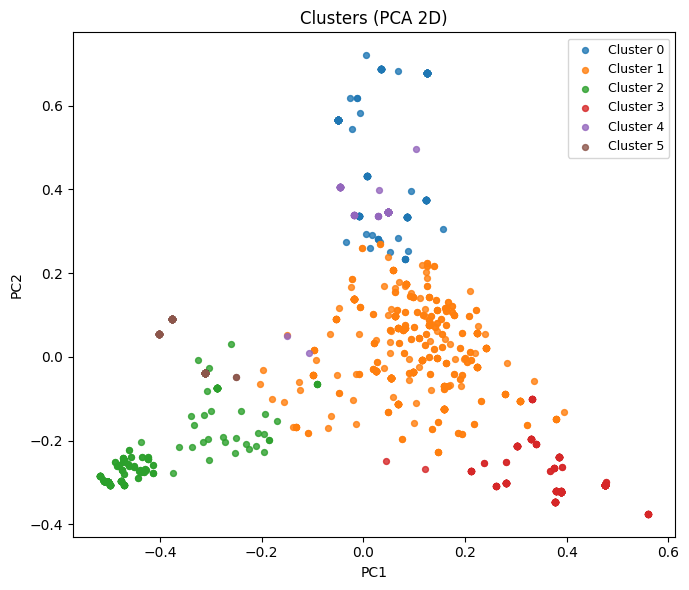

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X)

# Plot
plt.figure(figsize=(7,6))
uniq = np.unique(labels)
for lab in uniq:
    m = labels == lab
    marker = "x" if lab == -1 else "o"
    plt.scatter(XY[m,0], XY[m,1], s=18, alpha=0.8, label=f"Cluster {lab}", marker=marker)

plt.title("Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="best", fontsize=9, frameon=True)
plt.tight_layout()
plt.show()


In [62]:
map_of_labels.head()

,error_message,label
0,unmatched ')',1
1,closing parenthesis ']' does not match opening...,2
2,invalid syntax. perhaps you forgot a comma?,1
3,too many nested parentheses,2
4,closing parenthesis ']' does not match opening...,2


In [ ]:
# # Define the output file name
# output_filename = "cluster_messages_with_initial_file_hash.xlsx"

# # Use pd.ExcelWriter as a context manager
# with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
#     for i in range(6):
        
#         # Filter for the current cluster
#         selected_cluster = map_of_labels[map_of_labels["label"] == i]
        
#         # Define the sheet name
#         sheet_name = f"Cluster_{i}"
        
#         # Write this cluster's DataFrame to a specific sheet
#         selected_cluster.to_excel(writer, sheet_name=sheet_name, index=False)

# print(f"All clusters saved to {output_filename}")

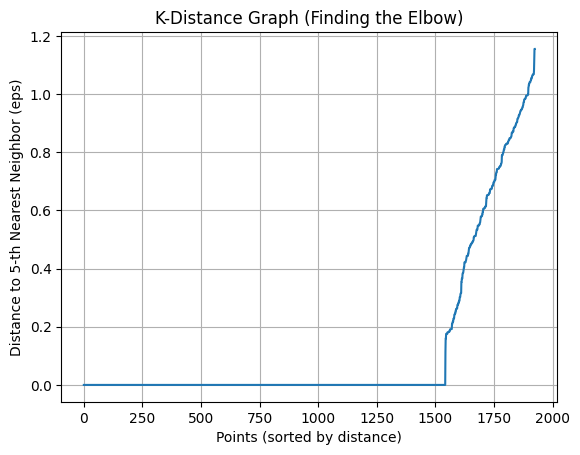

In [ ]:
# from sklearn.neighbors import NearestNeighbors
# import numpy as np
# import matplotlib.pyplot as plt

# # --- Assume 'embeddings' already exists from the previous step ---
# # embeddings = model.encode(texts)

# # 1. Set min_samples
# # Let's start with a value of 5
# min_samples = 5 

# # 2. Calculate nearest neighbor distances
# # n_neighbors should be min_samples
# nn = NearestNeighbors(n_neighbors=min_samples)
# nn.fit(X)
# distances, indices = nn.kneighbors(X)

# # 3. Get the distance to the k-th neighbor (k=min_samples)
# # We sort the k-th distances (the last column of 'distances')
# kth_distances = np.sort(distances[:, min_samples-1], axis=0)

# # 4. Plot the k-distance graph
# plt.plot(kth_distances)
# plt.ylabel(f"Distance to {min_samples}-th Nearest Neighbor (eps)")
# plt.xlabel("Points (sorted by distance)")
# plt.title("K-Distance Graph (Finding the Elbow)")
# plt.grid(True)
# plt.show()

In [ ]:
# from sklearn.cluster import DBSCAN

# # --- Assume 'embeddings' and 'texts' exist ---

# # 1. Set parameters from your analysis
# # (We'll use hypothetical values from our "elbow" plot)
# chosen_eps = 0.2 
# chosen_min_samples = 5

# # 2. Initialize and run DBSCAN
# dbscan = DBSCAN(eps=chosen_eps, min_samples=chosen_min_samples)
# dbscan.fit(X)

# # 3. Get the cluster assignments
# cluster_labels = dbscan.labels_

# print(f"Cluster assignments: {cluster_labels}")
# # Example output: [ 0  0 -1  1  1  0]

Cluster assignments: [ 0  1  2 ... 13  6  9]


In [ ]:
# # Find the number of unique clusters (excluding noise)
# num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
# print(f"\nFound {num_clusters} clusters and {np.sum(cluster_labels == -1)} noise points.")

# # Print each cluster's texts
# for i in range(num_clusters):
#     print(f"\n--- Cluster {i} ---")
#     for j in range(len(combined)):
#         if cluster_labels[j] == i:
#             print(combined[j])

# # Print the noise points
# print("\n--- Noise Points (Label -1) ---")
# for j in range(len(combined)):
#     if cluster_labels[j] == -1:
#         print(combined[j])


Found 62 clusters and 353 noise points.

--- Cluster 0 ---
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'
unmatched ')'

--- Cluster 1 ---
closing parenthesis ']' does not match opening parenthesis '('
closing parenthesis ']' does not match opening parenthesis '('
closing parenthesis ']' does not match opening parenthesis '('
closing parenthesis ']' does not match opening parenthesis '('
closing parenthesis ']' does not match opening parenthesis '('
closing parenthesis ']' does not match opening parenthesis '('
closing parenthesis ']' does not match opening parenthesis '('
closing parenthesis ']' does not match opening parenthesis '

In [ ]:
# print(len(cluster_labels))

1925


Running PCA to reduce dimensions for plotting...


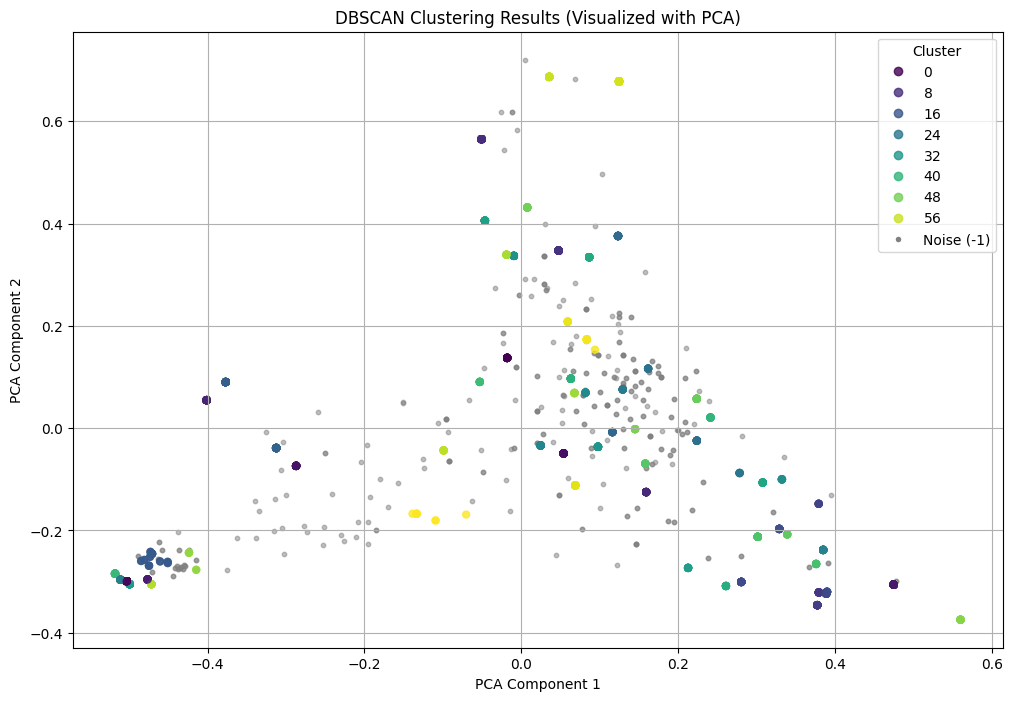

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import pandas as pd
# import numpy as np

# # --- ASSUMPTIONS ---
# # You must have these variables from your previous steps:
# # embeddings: Your (N_samples, N_features) numpy array of BERT embeddings
# # cluster_labels: The (N_samples,) numpy array of labels from dbscan.fit()

# # 1. Reduce Dimensions with PCA
# print("Running PCA to reduce dimensions for plotting...")
# pca = PCA(n_components=2, random_state=42)
# reduced_embeddings = pca.fit_transform(X)

# # 2. Create a DataFrame for easy plotting
# plot_df = pd.DataFrame({
#     'pca_dim1': reduced_embeddings[:, 0],
#     'pca_dim2': reduced_embeddings[:, 1],
#     'cluster': cluster_labels
# })

# # 3. Separate noise points from clustered points
# noise_df = plot_df[plot_df['cluster'] == -1]
# clustered_df = plot_df[plot_df['cluster'] != -1]

# # 4. Create the scatter plot
# plt.figure(figsize=(12, 8))

# # Plot noise points first (grey, smaller, slightly transparent)
# plt.scatter(noise_df['pca_dim1'], noise_df['pca_dim2'],
#             c='grey',
#             s=10,
#             alpha=0.5,
#             label='Noise (Cluster -1)')

# # Plot the clustered points
# # We use 'cluster' for color and a colormap
# scatter = plt.scatter(clustered_df['pca_dim1'], clustered_df['pca_dim2'],
#                       c=clustered_df['cluster'],
#                       cmap='viridis',  # 'viridis', 'tab20', 'Spectral' are good colormaps
#                       s=25,
#                       alpha=0.8,
#                       label='Clustered Points')

# # 5. Add labels, title, and legend
# plt.title('DBSCAN Clustering Results (Visualized with PCA)')
# plt.xlabel('PCA Component 1')
# plt.ylabel('PCA Component 2')

# # Create a legend for the clusters
# # This gets the unique cluster colors and labels them
# unique_clusters = np.unique(clustered_df['cluster'])
# if len(unique_clusters) > 0:
#     handles, labels = scatter.legend_elements()
#     # Add the "Noise" label manually to the legend
#     handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Noise',
#                                markerfacecolor='grey', markersize=5))
#     labels.append('Noise (-1)')
#     plt.legend(handles=handles, labels=labels, title="Cluster")
# else:
#     plt.legend(title="Cluster") # Will just show noise if no clusters found
    
# plt.grid(True)
# # plt.savefig("dbscan_cluster_plot.png")

# # print("Plot saved as 'dbscan_cluster_plot.png'")